In [ ]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Carga del dataset desde la URL
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
df = pd.read_csv(url)

# Selección de la columna de temperatura y escalado
data = df['T (degC)'].values.reshape(-1, 1)  # Convertimos a un arreglo 2D para escalado
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [ ]:
# Función para crear secuencias de entrada (X) y salida (y)
def create_sequences(data, seq_length=72):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Definición de la longitud de la secuencia y creación de los conjuntos de entrenamiento y prueba
seq_length = 72  # 3 días de observaciones
X, y = create_sequences(data_scaled, seq_length)

# División en entrenamiento y prueba (80% entrenamiento, 20% prueba)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# Creación del modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compilación del modelo con optimizador Adam y función de pérdida MAE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Configuración de early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,
                    batch_size=64, callbacks=[early_stopping], verbose=1)


Epoch 1/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 954s 181ms/step - loss: 0.0281 - val_loss: 0.0042
Epoch 2/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 967s 178ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 3/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 982s 178ms/step - loss: 0.0084 - val_loss: 0.0029
Epoch 4/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 977s 177ms/step - loss: 0.0081 - val_loss: 0.0035
Epoch 5/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 952s 181ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 6/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 995s 184ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 7/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 962s 183ms/step - loss: 0.0079 - val_loss: 0.0030
Epoch 8/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 976s 182ms/step - loss: 0.0078 - val_loss: 0.0039
Epoch 9/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 985s 183ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 10/10
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 968s 180ms/step - loss: 0.0078 - val_loss: 0.0039


2628/2628 ━━━━━━━━━━━━━━━━━━━━ 93s 35ms/step
Mean Absolute Error: 0.16697916829291348


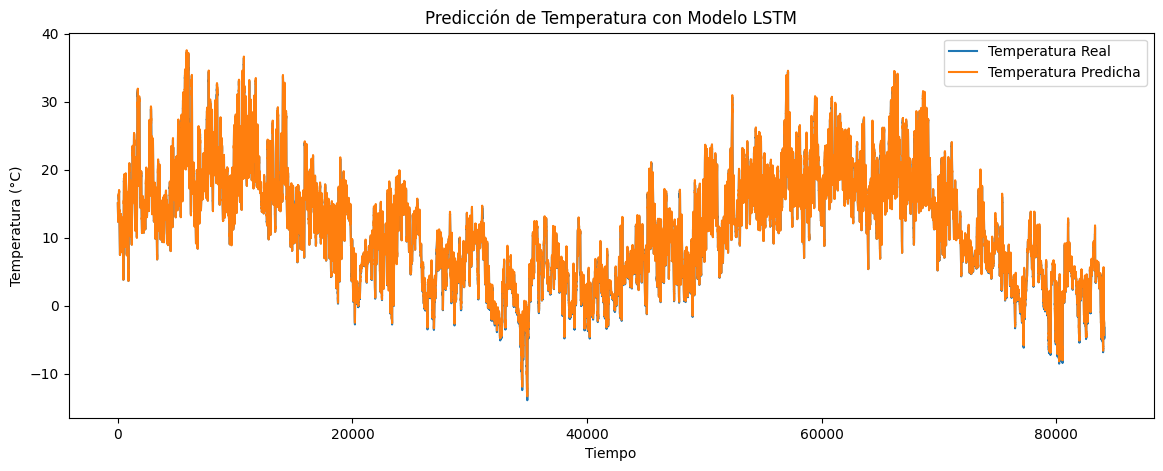

In [7]:
# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

# Desescalado de los datos para visualización
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Calcular MAE después de las predicciones
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f'Mean Absolute Error: {mae}')

# Visualización de los resultados
plt.figure(figsize=(14, 5))
plt.plot(y_test_unscaled, label='Temperatura Real')
plt.plot(y_pred_unscaled, label='Temperatura Predicha')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.title('Predicción de Temperatura con Modelo LSTM')
plt.show()
